In [3]:
import os
import numpy as np
import pandas as pd
import skimage.io as skio
from datetime import datetime
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
from shapely.geometry import box
from skimage.draw import polygon
from shapely import wkt

from agrobrain_image_processing.canopy.canopy import canopy_by_hsv
from agrobrain_canopy.canopy_cover.canopy_cover import CanopyCover

from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

os.environ["NAMESPACE"]="research"
os.environ["PROFILE"]="local"
from agrobrain_util.runtime.evironment import RuntimeEnv

env = RuntimeEnv()

# infestation_level_csv_path = "data/canopy_coverage/tiles_infestation_level_1000_images.csv"
# infestation_level_csv_path = "data/canopy_coverage/tiles_infestation_coverage_21_images.csv"
# infestation_level_csv_path = "data/canopy_coverage/tiles_infestation_coverage_21_images_1.csv"
infestation_level_csv_path = "data/canopy_coverage/tiles_infestation_coverage_output_365_images_from_3_orders.csv"

output_dir = "data/canopy_coverage"
infestation_level_df = pd.read_csv(infestation_level_csv_path)

# SET EXAMPLE IMAGE ATTRIBUTES
example_image_id = infestation_level_df['image_id'][0]
example_im_path = env.download_image(int(example_image_id))
example_image = skio.imread(example_im_path)
example_image_shape = example_image.shape

# # IN CASE THERE IS DATALOOP ANNOTATIONS:
# dl_project_name = "Taranis AI Annotation Projects"
# dl_annotations_dataset_name = "anafa_2023_07_17_infestation_21_images"
# dl_local_data_dir = "data/dataloop"

could not find stamp in environment variables
could not find stamp in environment variables
could not find KUBEFLOW_API_BASIC_AUTH_TOKEN in environment variables
could not find AI_RABBITMQ_CONNECTION_STRING in environment variables
could not find AI_MONGO_DB_CONNECTION_STRING in environment variables
could not find TARANIS_DB_CONNECTION_STRING in environment variables
could not find GLOBAL_DB_CONNECTION_STRING in environment variables
could not find AI_MONGO_DB_CONNECTION_STRING_NEW in environment variables
could not find MONGO_DB_CONNECTION_STRING in environment variables


In [11]:
type(images_list[0])

int

In [12]:
# CREATE IMAGES IDS LIST OF FULL ORDER
# orders_list_21_images_dataset = [395233 395830 398653 401923 403196 404108 404790 405004 405085 405497
#  406141 408509 410217 410524 410978 412903 413952 415522 415530 418528
#  423357]


chosen_orders_list = [395233, 404108, 423357]
images_list = []
# env.eti_api.get_images_data_by_orderid(395233, type_ids=[2])
for order_id in chosen_orders_list:
    order_images = env.eti_api.get_image_list_by_orderid(order_id, type_ids=[2])
    random_items = np.random.choice(order_images, size=2, replace=False).tolist()
    images_list.extend(random_items)

# len(images_list)
infestation_21_image_ids_json_file_path = "data/infestation_6_images_from_3_orders.json"

# infestation_21_image_ids_json_file_path = "data/infestation_365_images_from_3_orders.json"
with open(infestation_21_image_ids_json_file_path, "w") as json_file:
    json.dump(images_list, json_file)

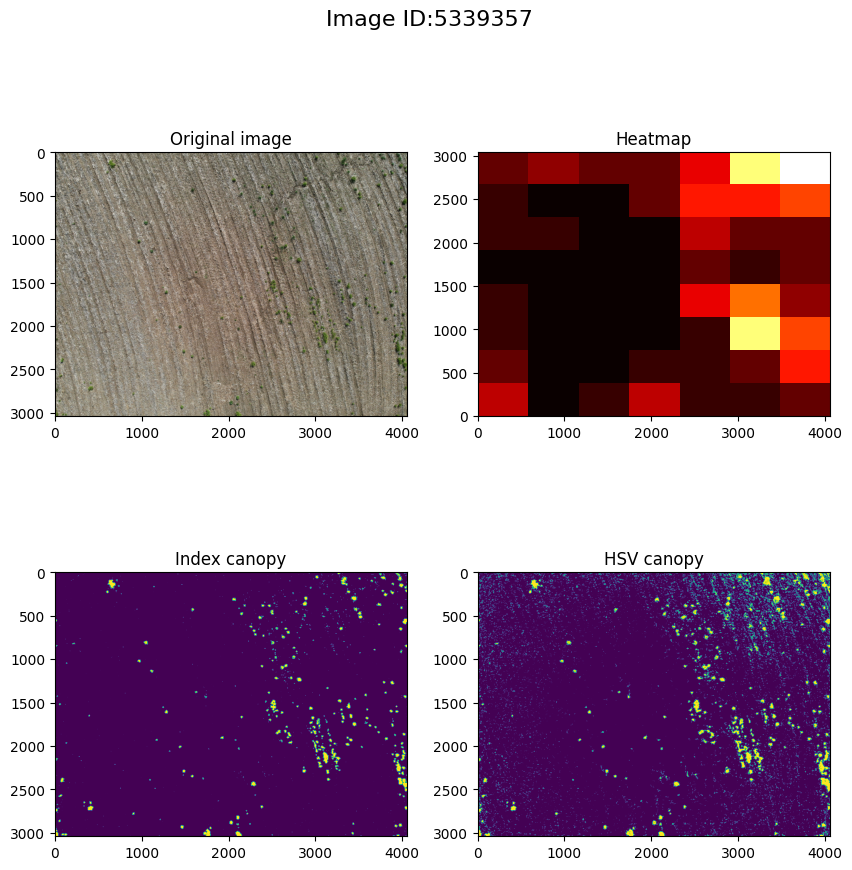

In [33]:
# CREATE IMAGE HEATMAP
image_id = np.random.choice(infestation_level_df['image_id'].values)
# image_id = 5164847
# image_id = 5372412


image_tiles_df = infestation_level_df[infestation_level_df['image_id'] == image_id]

image_path = env.download_image(int(image_id))
image = skio.imread(image_path)

index_canopy_map = CanopyCover.canopy_cover(image_path)[0].astype(np.uint8) * 255
hsv_canopy_map = canopy_by_hsv(image).astype(np.uint8) * 255


image_height, image_width, _ = example_image_shape
heatmap = np.zeros((image_height, image_width))
for coords, val in zip(image_tiles_df["box_coords"], image_tiles_df["infestation_level"]):
    coords = wkt.loads(coords)
    min_x, min_y, max_x, max_y = map(int, coords.bounds)
    heatmap[min_x:max_x, min_y:max_y] += val
    # heatmap[min_x:max_x, max_y:min_y] += val

heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

# SHOW HEATMAP

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

# image_plot = axes[0, 0].imshow(image, cmap='hot', interpolation='nearest', origin='lower')
image_plot = axes[0, 0].imshow(image)
axes[0, 0].set_title('Original image')

heatmap = np.flipud(heatmap)
heatmap_plot = axes[0, 1].imshow(heatmap, cmap='hot', interpolation='nearest', origin='lower')
axes[0, 1].set_title('Heatmap')

im1_plot = axes[1, 0].imshow(index_canopy_map)
axes[1, 0].set_title('Index canopy')

im2_plot = axes[1, 1].imshow(hsv_canopy_map)
axes[1, 1].set_title('HSV canopy')


# cbar = plt.colorbar(heatmap_plot, ax=axes[0, 1])
# cbar.set_label("Infestation level")
plt.suptitle(f"Image ID:{image_id}", fontsize=16)
plt.show()

In [34]:
infestation_level_df.columns

Index(['Unnamed: 0', 'image_id', 'box_index', 'orderID',
       'image_hsv_canopy_percent', 'image_canopy_index_percent', 'box_coords',
       'hsv_canopy_percent', 'index_canopy_percent', 'canopy_cover_avg',
       'infestation_level'],
      dtype='object')

In [87]:
# SAVE CANOPY COVER IMAGES SUBPLOTS AND HISTOGRAMS - TWO HEATMAPS


images_ids = np.unique(infestation_level_df['image_id'].values)

canopy_images_folder = os.path.join('images', f"canopy_cover_21_images")
os.makedirs(canopy_images_folder, exist_ok=True)

dl_annotations_csv_path = "data/infestation_coverage/dataloop_annotations_boxes_dataset_anafa_2023_07_17_infestation_21_images.csv"
dl_annotations_df = pd.read_csv(dl_annotations_csv_path)

for image_id in tqdm(images_ids):
    image_tiles_df = infestation_level_df[infestation_level_df['image_id'] == image_id].reset_index(drop=True)

    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
    
    # IMAGES
    image_path = env.download_image(int(image_id))
    image = skio.imread(image_path)
    index_canopy_map = CanopyCover.canopy_cover(image_path)[0].astype(np.uint8) * 255
    hsv_canopy_map = canopy_by_hsv(image).astype(np.uint8) * 255

    image_height, image_width, _ = example_image_shape
    heatmap = np.zeros((image_height, image_width))
    for coords, val in zip(image_tiles_df["box_coords"], image_tiles_df["infestation_level"]):
        coords = wkt.loads(coords)
        min_x, min_y, max_x, max_y = map(int, coords.bounds)
        heatmap[min_x:max_x, min_y:max_y] += val
        # heatmap[min_x:max_x, max_y:min_y] += val

    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

    # image_plot = axes[0, 0].imshow(image, cmap='hot', interpolation='nearest', origin='lower')
    image_plot = axes[0, 0].imshow(image)
    axes[0, 0].set_title('Original image')

    heatmap = np.flipud(heatmap)
    heatmap_plot = axes[2, 0].imshow(heatmap, cmap='hot', interpolation='nearest', origin='lower')
    axes[2, 0].set_title('Heatmap')
    
    hsv_map_plot = axes[0, 1].imshow(hsv_canopy_map)
    axes[0, 1].set_title('HSV canopy')

    index_map_plot = axes[0, 2].imshow(index_canopy_map)
    axes[0, 2].set_title('Index canopy')


    # HISTOGRAMS

    data_lists = {"canopy_cover_avg": image_tiles_df['canopy_cover_avg'],
                  "hsv_canopy_percent": image_tiles_df['hsv_canopy_percent'],
                  "index_canopy_percent": image_tiles_df['index_canopy_percent']}
    # fig, axes = plt.subplots(1, 3, figsize=(10, 4))

    for i in range(len(data_lists)):
        data = data_lists[list(data_lists.keys())[i]]
        axes[1, i].hist(data, bins=20, color='lightseagreen', alpha=0.7)
        axes[1, i].set_xlabel('Canopy coverage percent')
        axes[1, i].set_ylabel('Frequency')
        axes[1, i].set_title(list(data_lists.keys())[i])
    
    # DATALOOP ANNOTATIONS
    
    image_df = dl_annotations_df[dl_annotations_df['image_id']==image_id]
    color = 'black'
    
    axes[2, 1].imshow(image)
    for i, row in image_df.iterrows():
        bounding_box = wkt.loads(row['box_poly'])
        alpha = 1 - row['infestation_average']/100
        box_patch = PolygonPatch(np.array(bounding_box.exterior.coords), facecolor='none', edgecolor='lightsteelblue', linewidth=2, alpha=alpha, color=color)
        axes[2, 1].add_patch(box_patch)

    axes[2, 1].set_title(f"Dataloop annotations")
    plt.tight_layout()

    plt.savefig(os.path.join(canopy_images_folder, f'canopy_coverage_hist_and_heatmaps_{image_id}.jpg'))
    # plt.show()


"[{'x': 2316, 'y': 1520, 'z': 0}, {'x': 2895, 'y': 1900, 'z': 0}]"

In [107]:
# SAVE CANOPY COVER IMAGES SUBPLOTS AND HISTOGRAMS
from shapely.geometry import Point, Polygon
from matplotlib.patches import Polygon as PolygonPatch


images_ids = np.unique(infestation_level_df['image_id'].values)

canopy_images_folder = os.path.join('images', f"canopy_cover_21_images")
os.makedirs(canopy_images_folder, exist_ok=True)

dl_annotations_csv_path = "data/infestation_coverage/dataloop_annotations_boxes_dataset_anafa_2023_07_17_infestation_21_images.csv"
dl_annotations_df = pd.read_csv(dl_annotations_csv_path)

for image_id in tqdm(images_ids):
    image_tiles_df = infestation_level_df[infestation_level_df['image_id'] == image_id].reset_index(drop=True)

    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10,10))

    # IMAGES
    image_path = env.download_image(int(image_id))
    image = skio.imread(image_path)
    index_canopy_map = CanopyCover.canopy_cover(image_path)[0].astype(np.uint8) * 255
    hsv_canopy_map = canopy_by_hsv(image).astype(np.uint8) * 255

    image_height, image_width, _ = example_image_shape
    heatmap = np.zeros((image_height, image_width))
    for coords, val in zip(image_tiles_df["box_coords"], image_tiles_df["infestation_level"]):
        coords = wkt.loads(coords)
        min_x, min_y, max_x, max_y = map(int, coords.bounds)
        heatmap[min_x:max_x, min_y:max_y] += val
        # heatmap[min_x:max_x, max_y:min_y] += val

    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

    # image_plot = axes[0, 0].imshow(image, cmap='hot', interpolation='nearest', origin='lower')
    image_plot = axes[0, 0].imshow(image)
    axes[0, 0].set_title('Original image')

    heatmap = np.flipud(heatmap)
    heatmap_plot = axes[2, 0].imshow(heatmap, cmap='hot', interpolation='nearest', origin='lower')
    axes[2, 0].set_title('Heatmap')
    
    hsv_map_plot = axes[0, 1].imshow(hsv_canopy_map)
    axes[0, 1].set_title('HSV canopy')

    index_map_plot = axes[0, 2].imshow(index_canopy_map)
    axes[0, 2].set_title('Index canopy')


    # HISTOGRAMS

    data_lists = {"canopy_cover_avg": image_tiles_df['canopy_cover_avg'],
                  "hsv_canopy_percent": image_tiles_df['hsv_canopy_percent'],
                  "index_canopy_percent": image_tiles_df['index_canopy_percent']}
    # fig, axes = plt.subplots(1, 3, figsize=(10, 4))

    for i in range(len(data_lists)):
        data = data_lists[list(data_lists.keys())[i]]
        axes[1, i].hist(data, bins=20, color='lightseagreen', alpha=0.7)
        axes[1, i].set_xlabel('Canopy coverage percent')
        axes[1, i].set_ylabel('Frequency')
        axes[1, i].set_title(list(data_lists.keys())[i])

    # DATALOOP ANNOTATIONS

    image_df = dl_annotations_df[dl_annotations_df['image_id']==image_id]
    color = 'black'

    axes[2, 1].imshow(image)
    for i, row in image_df.iterrows():
        bounding_box = wkt.loads(row['box_poly'])
        alpha = 1 - row['infestation_average']/100
        box_patch = PolygonPatch(np.array(bounding_box.exterior.coords), facecolor='none', edgecolor='lightsteelblue', linewidth=2, alpha=alpha, color=color)
        axes[2, 1].add_patch(box_patch)

    axes[2, 1].set_title(f"Dataloop annotations")
    plt.tight_layout()

    # plt.savefig(os.path.join(canopy_images_folder, f'canopy_coverage_hist_and_heatmaps_{image_id}.jpg'))
    # plt.show()


  0%|          | 0/21 [00:00<?, ?it/s]

/tmp/ipykernel_47528/2977958324.py:73: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  box_patch = PolygonPatch(np.array(bounding_box.exterior.coords), facecolor='none', edgecolor='lightsteelblue', linewidth=2, alpha=alpha, color=color)
 95%|█████████▌| 20/21 [11:12<00:35, 35.20s/it]/tmp/ipykernel_47528/2977958324.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10,10))


: 

: 

In [105]:
len(image_df)

10

In [49]:
dl_annotations_csv_path = "data/infestation_coverage/dataloop_annotations_boxes_dataset_anafa_2023_07_17_infestation_21_images.csv"
dl_annotations_df = pd.read_csv(dl_annotations_csv_path)

In [59]:
dl_annotations_df.columns

Index(['Unnamed: 0', 'id', 'datasetId', 'itemId', 'url', 'item', 'dataset',
       'type', 'label', 'attributes', 'coordinates', 'metadata', 'creator',
       'createdAt', 'updatedBy', 'updatedAt', 'hash', 'source', 'box_poly',
       'fitting_points', 'fitting_points_indexes', 'box_final_label',
       'infestation_average', 'votes', 'box_hsv_canopy_sum',
       'box_hsv_canopy_percent', 'box_canopy_index_sum',
       'box_canopy_index_percent', 'box_canopy_avg_hsv_index_sum', 'image_id'],
      dtype='object')

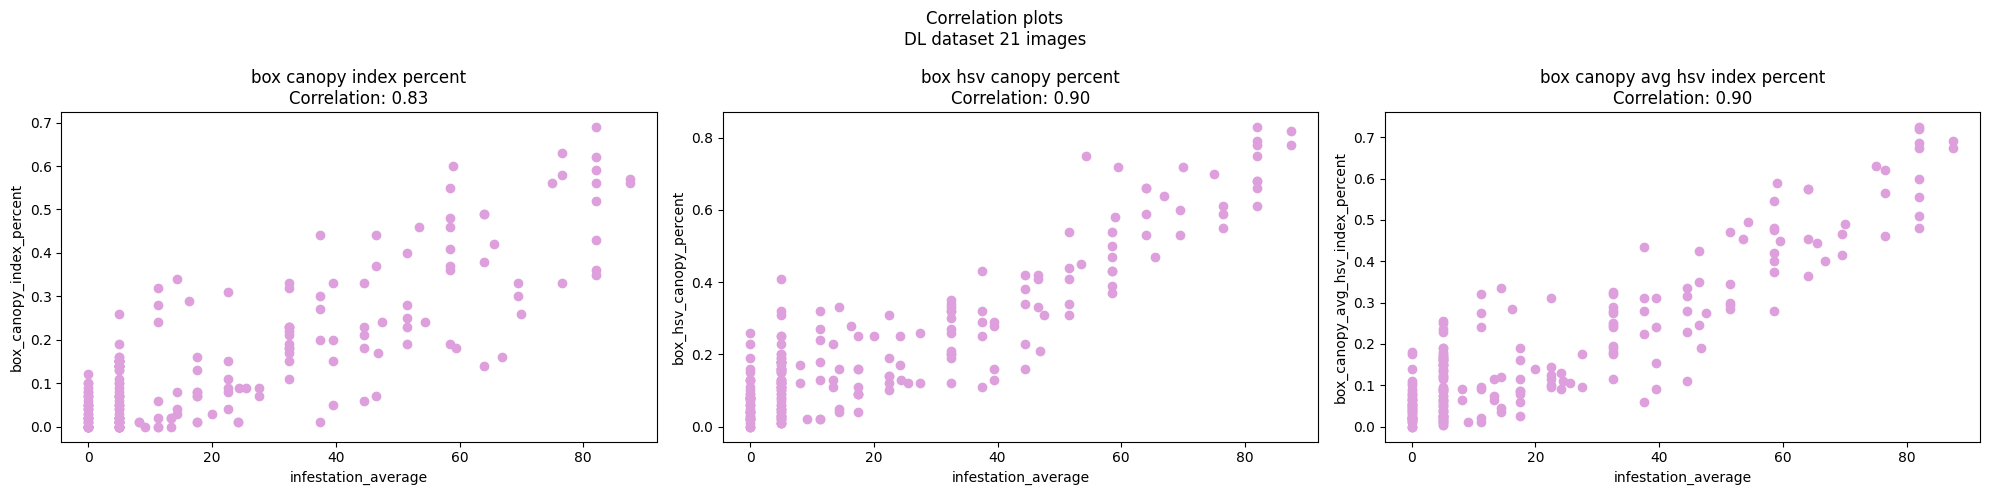

In [77]:
# CHECK CORRELATION BETWEEN DL ANNOTATIONS TO CANOPY COVERAGE PERCENTAGE

dl_annotations_df['box_canopy_avg_hsv_index_percent'] = (dl_annotations_df['box_canopy_index_percent'] + dl_annotations_df['box_hsv_canopy_percent']) / 2
box_features = ['box_canopy_index_percent', 'box_hsv_canopy_percent', 'box_canopy_avg_hsv_index_percent']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

for i, feature in enumerate(box_features):
    correlation = dl_annotations_df['infestation_average'].corr(dl_annotations_df[feature])
    axes[i].scatter(dl_annotations_df['infestation_average'], dl_annotations_df[feature], color="plum")
    axes[i].set_xlabel('infestation_average')
    axes[i].set_ylabel(feature)
    axes[i].set_title(f'{feature.replace("_"," ")}\nCorrelation: {correlation:.2f}')
plt.suptitle("Correlation plots\nDL dataset 21 images")
plt.tight_layout()
plt.show()


In [58]:
# SAVE IMAGES LIST TO JSON
image_ids = np.unique(dl_annotations_df['image_id'].values).tolist()
infestation_21_image_ids_json_file_path = "data/infestation_21_image_ids.json"
with open(infestation_21_image_ids_json_file_path, "w") as json_file:
    json.dump(image_ids, json_file)

In [ ]:
# PLOT DL ANNOTATIONS

images_ids = np.unique(dl_annotations_df['image_id'].values)

for image_id in images_ids:
    image_df = dl_annotations_df[dl_annotations_df['image_id']==image_id]
    color = 'black'
    fig, ax = plt.subplots()
    for i, row in image_df.iterrows():
        polygon = row['box_poly']
        polygon = wkt.loads(polygon)
        alpha = 1 - row['infestation_average']/100    
        x, y = polygon.exterior.xy
        ax.fill(x, y, color=color, alpha=alpha)
    plt.title(f"image ID: {image_id}")
    plt.show()

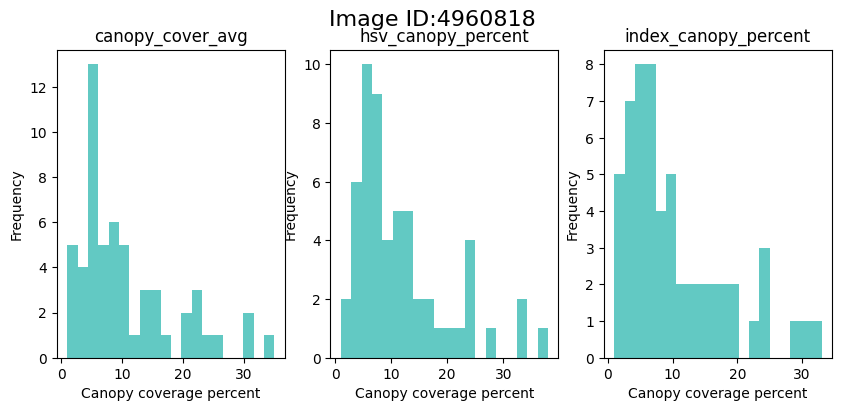

In [8]:
# HISTOGRAMS
image_df = infestation_level_df[infestation_level_df['image_id'] == image_id].reset_index(drop=True)

data_lists = {"canopy_cover_avg": image_df['canopy_cover_avg'],
                "hsv_canopy_percent": image_df['hsv_canopy_percent'],
                "index_canopy_percent": image_df['index_canopy_percent']}
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

for i in range(len(data_lists)):
    data = data_lists[list(data_lists.keys())[i]]
    axes[i].hist(data, bins=20, color='lightseagreen', alpha=0.7)
    axes[i].set_xlabel('Canopy coverage percent')
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(list(data_lists.keys())[i])



plt.suptitle(f"Image ID:{image_id}", fontsize=16)
plt.show()

# Compare prediction methods

  0%|          | 0/393 [00:29<?, ?it/s]


NameError: name 'example_image_shape' is not defined

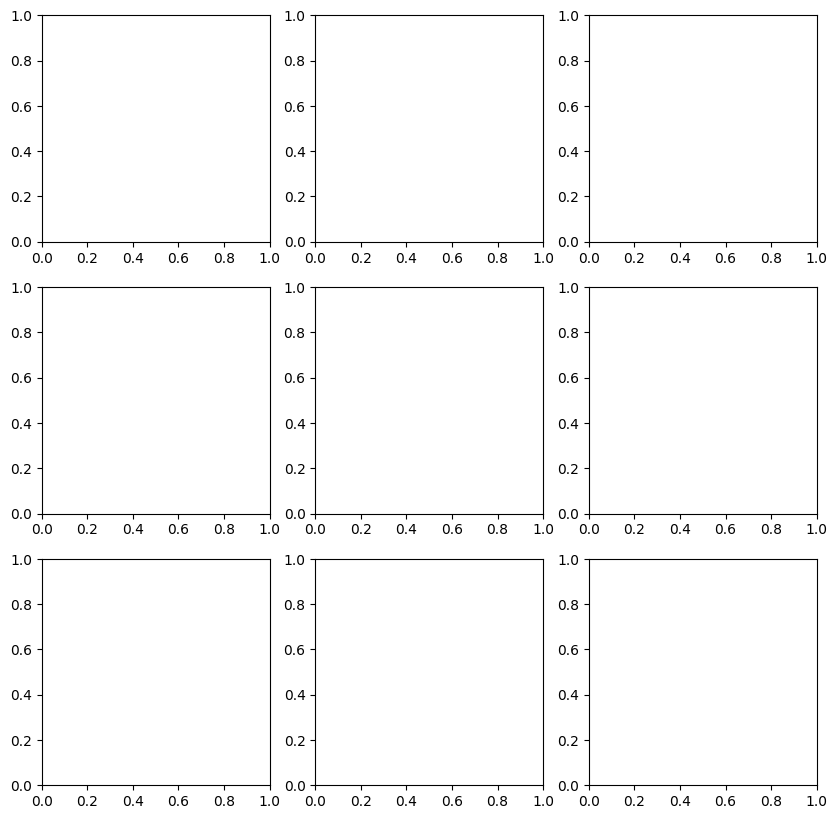

In [2]:
# SAVE CANOPY COVER IMAGES SUBPLOTS AND HISTOGRAMS
from shapely.geometry import Point, Polygon
from matplotlib.patches import Polygon as PolygonPatch


images_ids = np.unique(infestation_level_df['image_id'].values)

canopy_images_folder = os.path.join('images', f"365_images_from_3_orders")
os.makedirs(canopy_images_folder, exist_ok=True)


for image_id in tqdm(images_ids):
    image_tiles_df = infestation_level_df[infestation_level_df['image_id'] == image_id].reset_index(drop=True)

    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10,10))

    # IMAGES
    image_path = env.download_image(int(image_id))
    image = skio.imread(image_path)
    index_canopy_map = CanopyCover.canopy_cover(image_path)[0].astype(np.uint8) * 255
    hsv_canopy_map = canopy_by_hsv(image).astype(np.uint8) * 255

    image_height, image_width, _ = example_image_shape
    heatmap = np.zeros((image_height, image_width))
    for coords, val in zip(image_tiles_df["box_coords"], image_tiles_df["infestation_level"]):
        coords = wkt.loads(coords)
        min_x, min_y, max_x, max_y = map(int, coords.bounds)
        heatmap[min_x:max_x, min_y:max_y] += val
        # heatmap[min_x:max_x, max_y:min_y] += val

    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

    # image_plot = axes[0, 0].imshow(image, cmap='hot', interpolation='nearest', origin='lower')
    image_plot = axes[0, 0].imshow(image)
    axes[0, 0].set_title('Original image')

    heatmap = np.flipud(heatmap)
    heatmap_plot = axes[2, 0].imshow(heatmap, cmap='hot', interpolation='nearest', origin='lower')
    axes[2, 0].set_title('Heatmap')
    
    hsv_map_plot = axes[0, 1].imshow(hsv_canopy_map)
    axes[0, 1].set_title('HSV canopy')

    index_map_plot = axes[0, 2].imshow(index_canopy_map)
    axes[0, 2].set_title('Index canopy')


    # HISTOGRAMS

    data_lists = {"canopy_cover_avg": image_tiles_df['canopy_cover_avg'],
                  "hsv_canopy_percent": image_tiles_df['hsv_canopy_percent'],
                  "index_canopy_percent": image_tiles_df['index_canopy_percent']}
    # fig, axes = plt.subplots(1, 3, figsize=(10, 4))

    for i in range(len(data_lists)):
        data = data_lists[list(data_lists.keys())[i]]
        axes[1, i].hist(data, bins=20, color='lightseagreen', alpha=0.7)
        axes[1, i].set_xlabel('Canopy coverage percent')
        axes[1, i].set_ylabel('Frequency')
        axes[1, i].set_title(list(data_lists.keys())[i])

    plt.tight_layout()

    plt.savefig(os.path.join(canopy_images_folder, f'canopy_coverage_hist_and_heatmaps_{image_id}.jpg'))
    # plt.show()


In [3]:
np.unique(infestation_level_df['image_id'].values)[0]

5420396

In [7]:
image_tiles_df.columns

Index(['Unnamed: 0', 'image_id', 'box_index', 'orderID',
       'image_hsv_canopy_percent', 'image_canopy_index_percent', 'box_coords',
       'hsv_canopy_percent', 'index_canopy_percent', 'canopy_cover_avg',
       'infestation_level_by_mean_subtraction',
       'infestation_level_by_histograms_heuristics'],
      dtype='object')

In [14]:
infestation_level_df[infestation_level_df['image_id']==image_id]['orderID'][0]

395233

In [21]:
# SELECT RANDOM 2 IMAGES FROM EACH ORDER
grouped = infestation_level_df.groupby("orderID")
selected_images = pd.DataFrame(columns=infestation_level_df.columns)

# Loop through each group
for order_id, group_data in grouped:
    # Sample 2 random images from the current group
    sampled_images = group_data.sample(n=2, random_state=42)  # You can change the random_state

    # Append the sampled images to the selected_images DataFrame
    selected_images = selected_images.append(sampled_images)
selected_images = selected_images.reset_index(drop=True)

/tmp/ipykernel_37024/654288994.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  selected_images = selected_images.append(sampled_images)
/tmp/ipykernel_37024/654288994.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  selected_images = selected_images.append(sampled_images)
/tmp/ipykernel_37024/654288994.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  selected_images = selected_images.append(sampled_images)


In [29]:
infestation_level_df[infestation_level_df['image_id']==image_id]['orderID'].reset_index(drop=True)[0]

395233

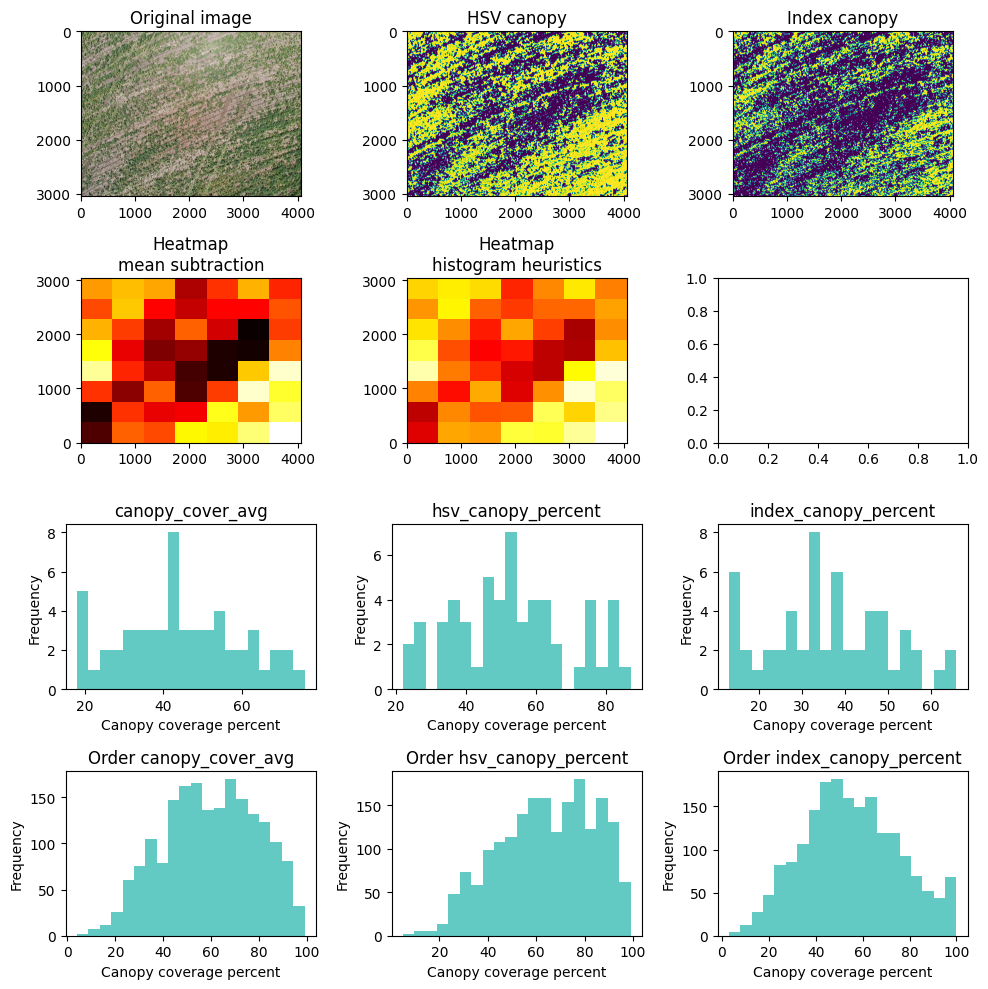

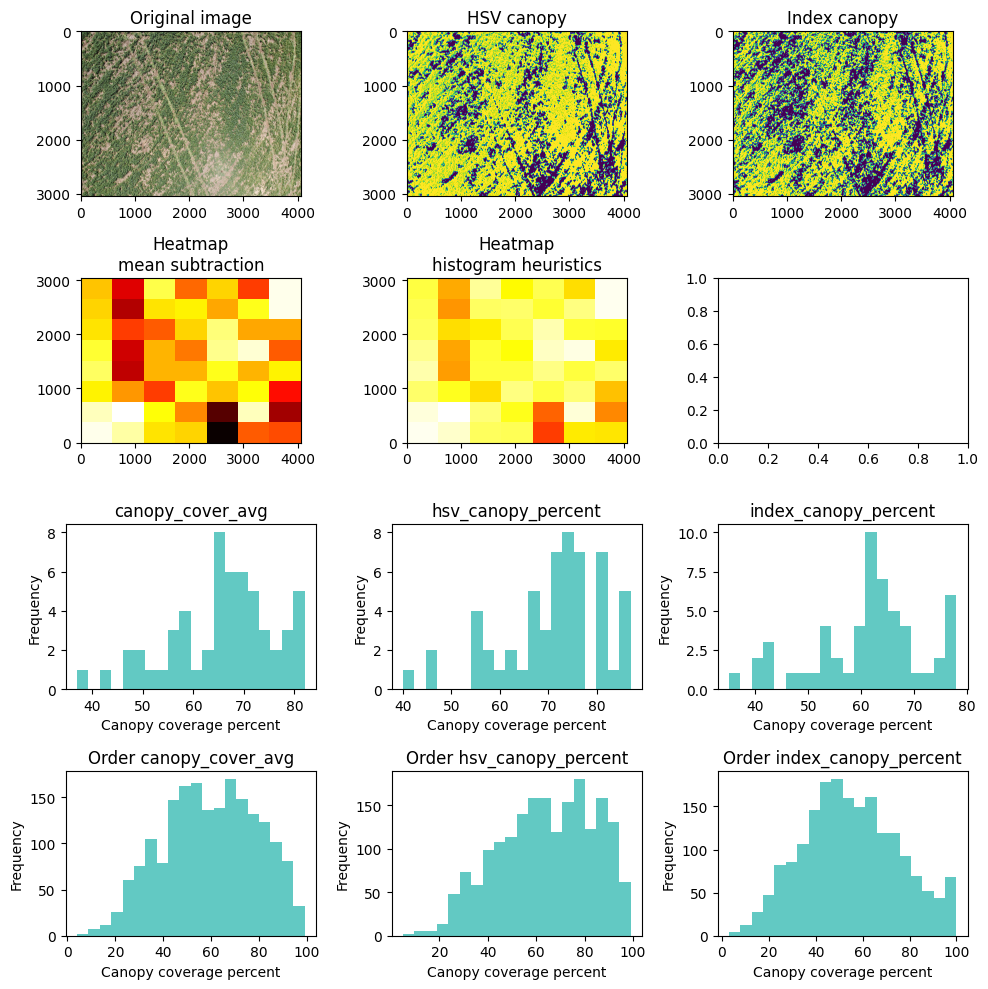

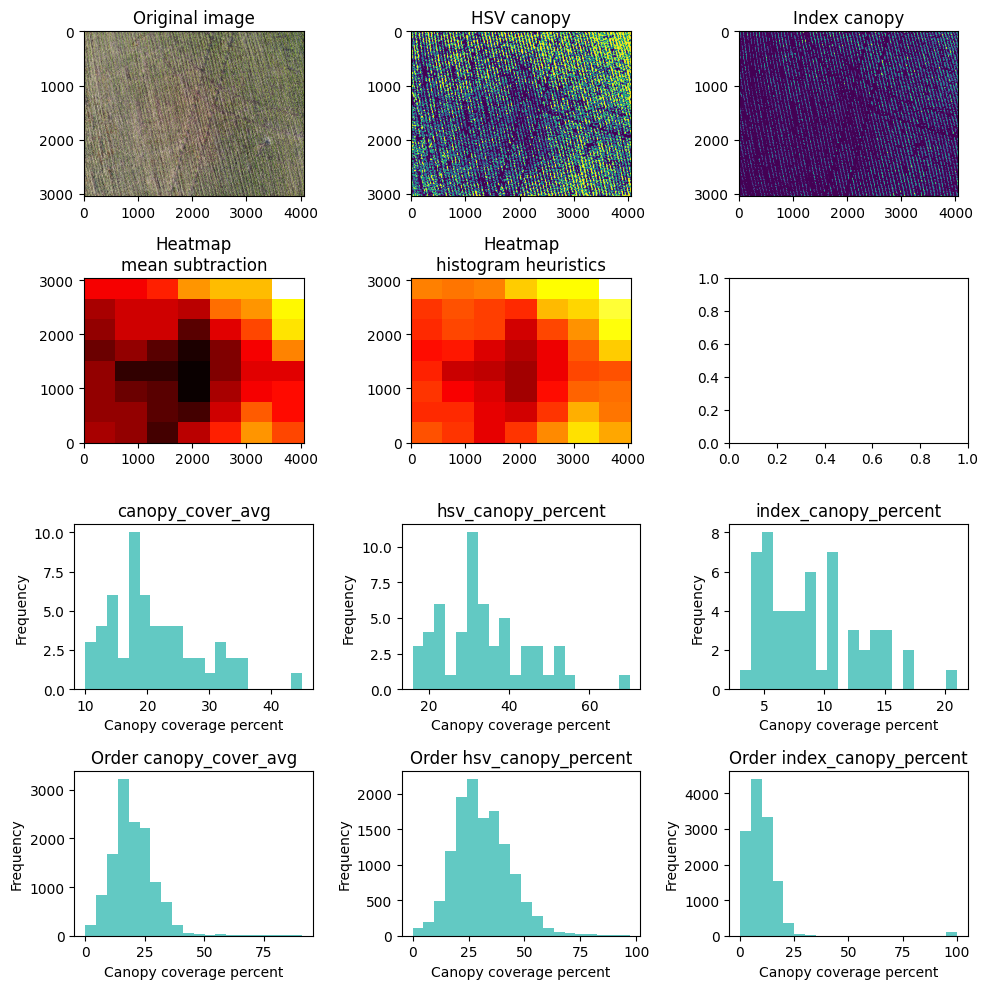

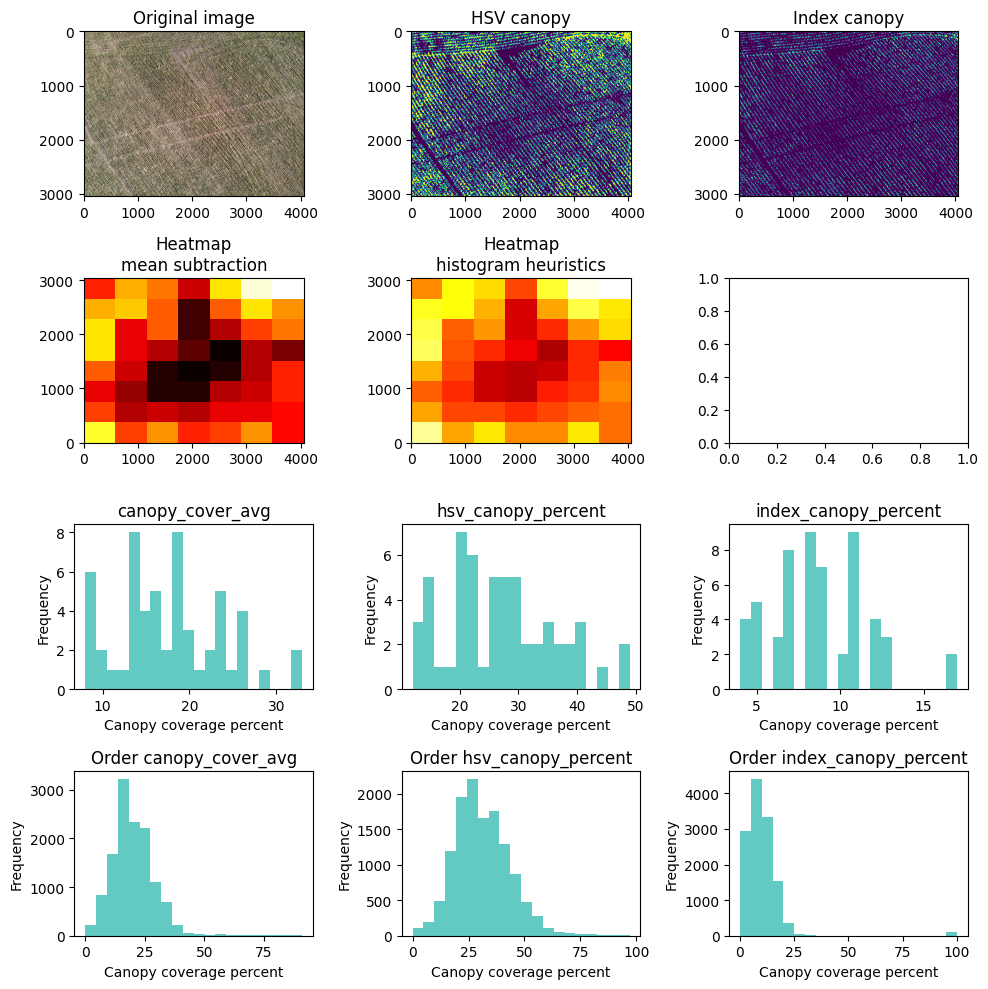

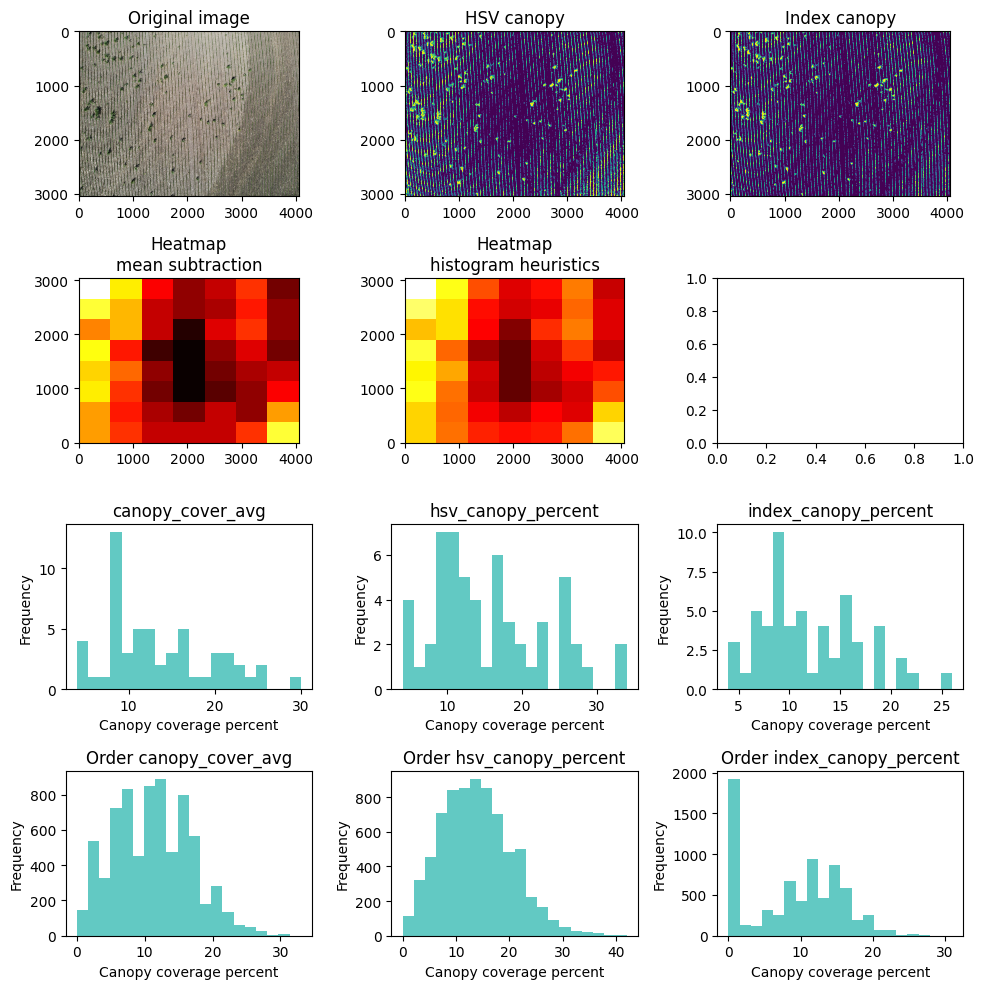

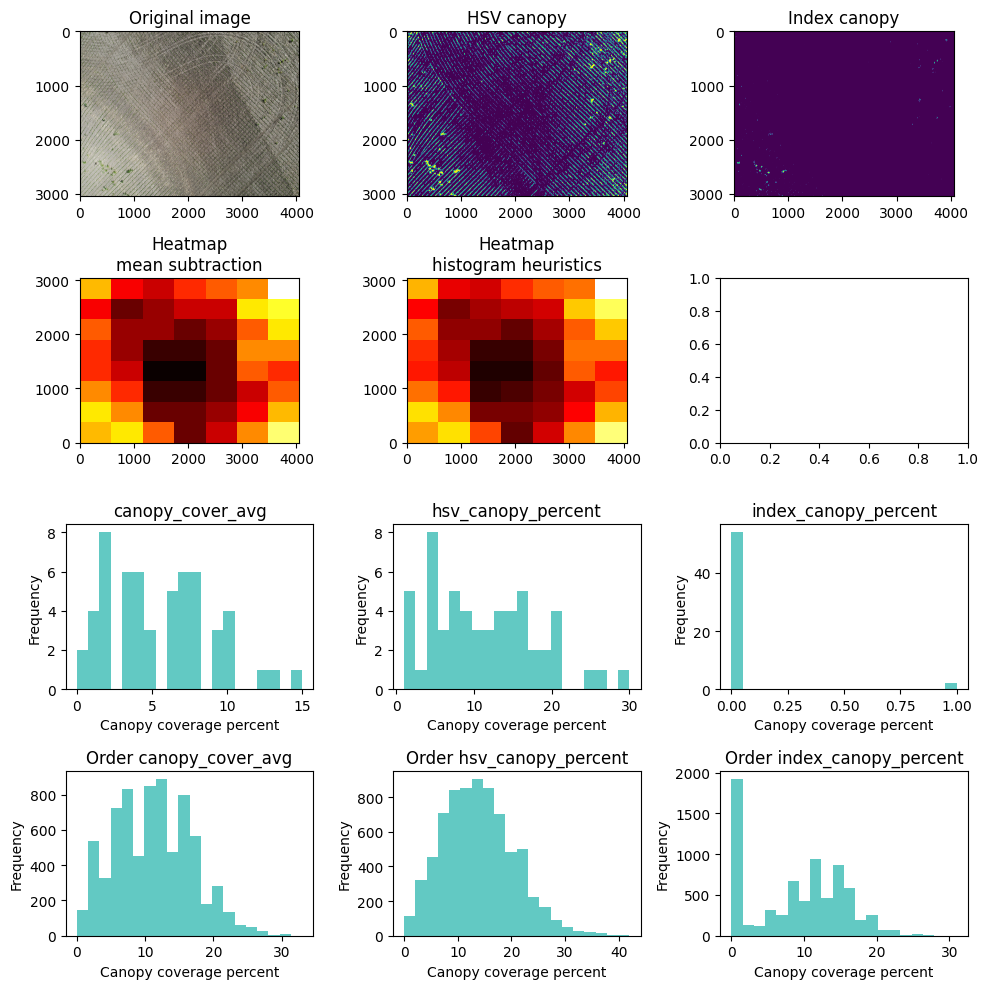

In [31]:
# SINGLE IMAGE
from shapely.geometry import Point, Polygon
from matplotlib.patches import Polygon as PolygonPatch


for image_id in selected_images['image_id']:
    # image_id = np.unique(infestation_level_df['image_id'].values)[0]
    order_id = infestation_level_df[infestation_level_df['image_id']==image_id]['orderID'].reset_index(drop=True)[0]

    canopy_images_folder = os.path.join('images', f"365_images_from_3_orders")
    os.makedirs(canopy_images_folder, exist_ok=True)

    image_tiles_df = infestation_level_df[infestation_level_df['image_id'] == image_id].reset_index(drop=True)
    order_tiles_df = infestation_level_df[infestation_level_df['orderID'] == order_id].reset_index(drop=True)

    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10,10))

    # IMAGES
    image_path = env.download_image(int(image_id))
    image = skio.imread(image_path)
    index_canopy_map = CanopyCover.canopy_cover(image_path)[0].astype(np.uint8) * 255
    hsv_canopy_map = canopy_by_hsv(image).astype(np.uint8) * 255

    image_height, image_width, _ = example_image_shape
    heatmap1 = np.zeros((image_height, image_width))
    heatmap2 = np.zeros((image_height, image_width))

    for coords, val1, val2 in zip(image_tiles_df["box_coords"], image_tiles_df["infestation_level_by_mean_subtraction"], image_tiles_df["infestation_level_by_histograms_heuristics"]):
        coords = wkt.loads(coords)
        min_x, min_y, max_x, max_y = map(int, coords.bounds)
        heatmap1[min_x:max_x, min_y:max_y] += val1
        heatmap2[min_x:max_x, min_y:max_y] += val2
        # heatmap[min_x:max_x, max_y:min_y] += val

    heatmap1 = (heatmap1 - heatmap1.min()) / (heatmap1.max() - heatmap1.min())
    heatmap2 = (heatmap2 - heatmap2.min()) / (heatmap2.max() - heatmap2.min())

    # image_plot = axes[0, 0].imshow(image, cmap='hot', interpolation='nearest', origin='lower')
    image_plot = axes[0, 0].imshow(image)
    axes[0, 0].set_title('Original image')

    heatmap1 = np.flipud(heatmap1)
    heatmap1_plot = axes[1, 0].imshow(heatmap1, cmap='hot', interpolation='nearest', origin='lower')
    axes[1, 0].set_title('Heatmap\nmean subtraction')

    heatmap2 = np.flipud(heatmap2)
    heatmap2_plot = axes[1, 1].imshow(heatmap2, cmap='hot', interpolation='nearest', origin='lower')
    axes[1, 1].set_title('Heatmap\nhistogram heuristics')

    hsv_map_plot = axes[0, 1].imshow(hsv_canopy_map)
    axes[0, 1].set_title('HSV canopy')

    index_map_plot = axes[0, 2].imshow(index_canopy_map)
    axes[0, 2].set_title('Index canopy')


    # HISTOGRAMS -IMAGE DF

    data_lists = {"canopy_cover_avg": image_tiles_df['canopy_cover_avg'],
                    "hsv_canopy_percent": image_tiles_df['hsv_canopy_percent'],
                    "index_canopy_percent": image_tiles_df['index_canopy_percent']}
    # fig, axes = plt.subplots(1, 3, figsize=(10, 4))

    for i in range(len(data_lists)):
        data = data_lists[list(data_lists.keys())[i]]
        axes[2, i].hist(data, bins=20, color='lightseagreen', alpha=0.7)
        axes[2, i].set_xlabel('Canopy coverage percent')
        axes[2, i].set_ylabel('Frequency')
        axes[2, i].set_title(list(data_lists.keys())[i])
        
    # HISTOGRAMS -ORDER DF

    data_lists = {"canopy_cover_avg": order_tiles_df['canopy_cover_avg'],
                    "hsv_canopy_percent": order_tiles_df['hsv_canopy_percent'],
                    "index_canopy_percent": order_tiles_df['index_canopy_percent']}
    # fig, axes = plt.subplots(1, 3, figsize=(10, 4))

    for i in range(len(data_lists)):
        data = data_lists[list(data_lists.keys())[i]]
        axes[3, i].hist(data, bins=20, color='lightseagreen', alpha=0.7)
        axes[3, i].set_xlabel('Canopy coverage percent')
        axes[3, i].set_ylabel('Frequency')
        axes[3, i].set_title(F"Order {list(data_lists.keys())[i]}")

    plt.tight_layout()

    plt.savefig(os.path.join(canopy_images_folder, f'canopy_coverage_hist_and_heatmaps_{image_id}.jpg'))
    plt.show()
